# Green Sentiment

by Lucas Kiesel and Julian Menon

This is a small presentation showing our steps/tries with some added explanations.

In [1]:
# imports
from PIL import Image

First we worked on getting quality satellite images of the cities that had their administrative borders cut correctly to fit only the city in it. The goal was to create an image dataset of the cities to calculate green-scores for each city. Let us look at one example from the image dataset.

RGBA


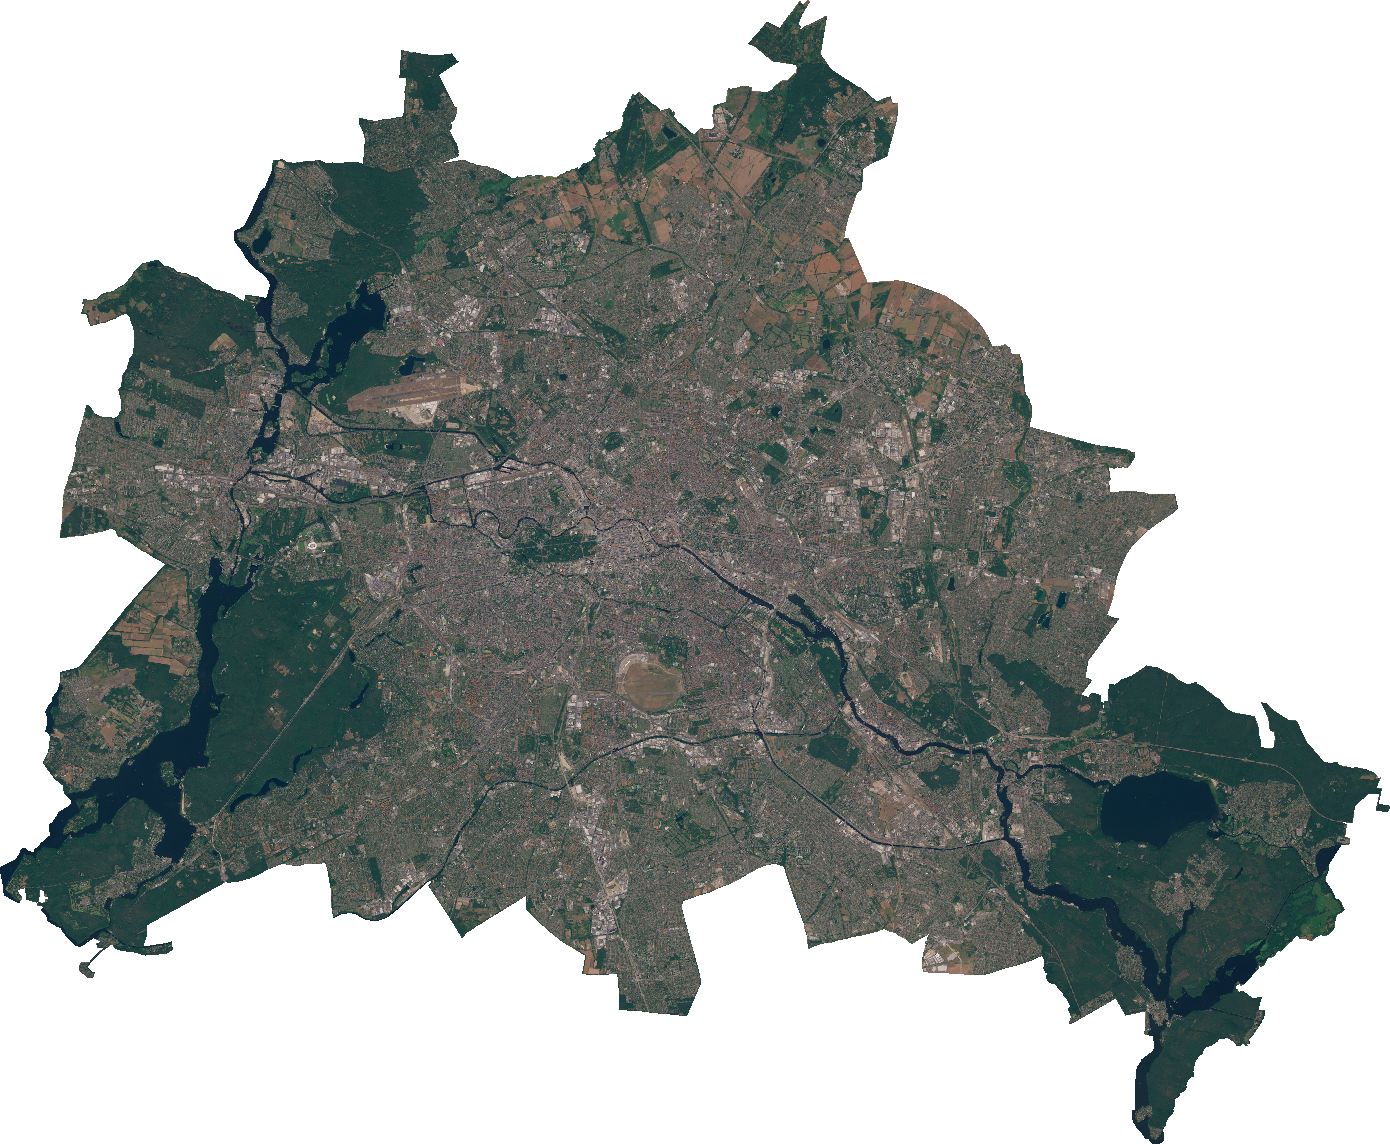

In [2]:
image_berlin = Image.open(r"city_image_dataset/berlin.png")
print(image_berlin.mode)
image_berlin

Berlin is not rich in greenery compared to our next example: Göttingen.

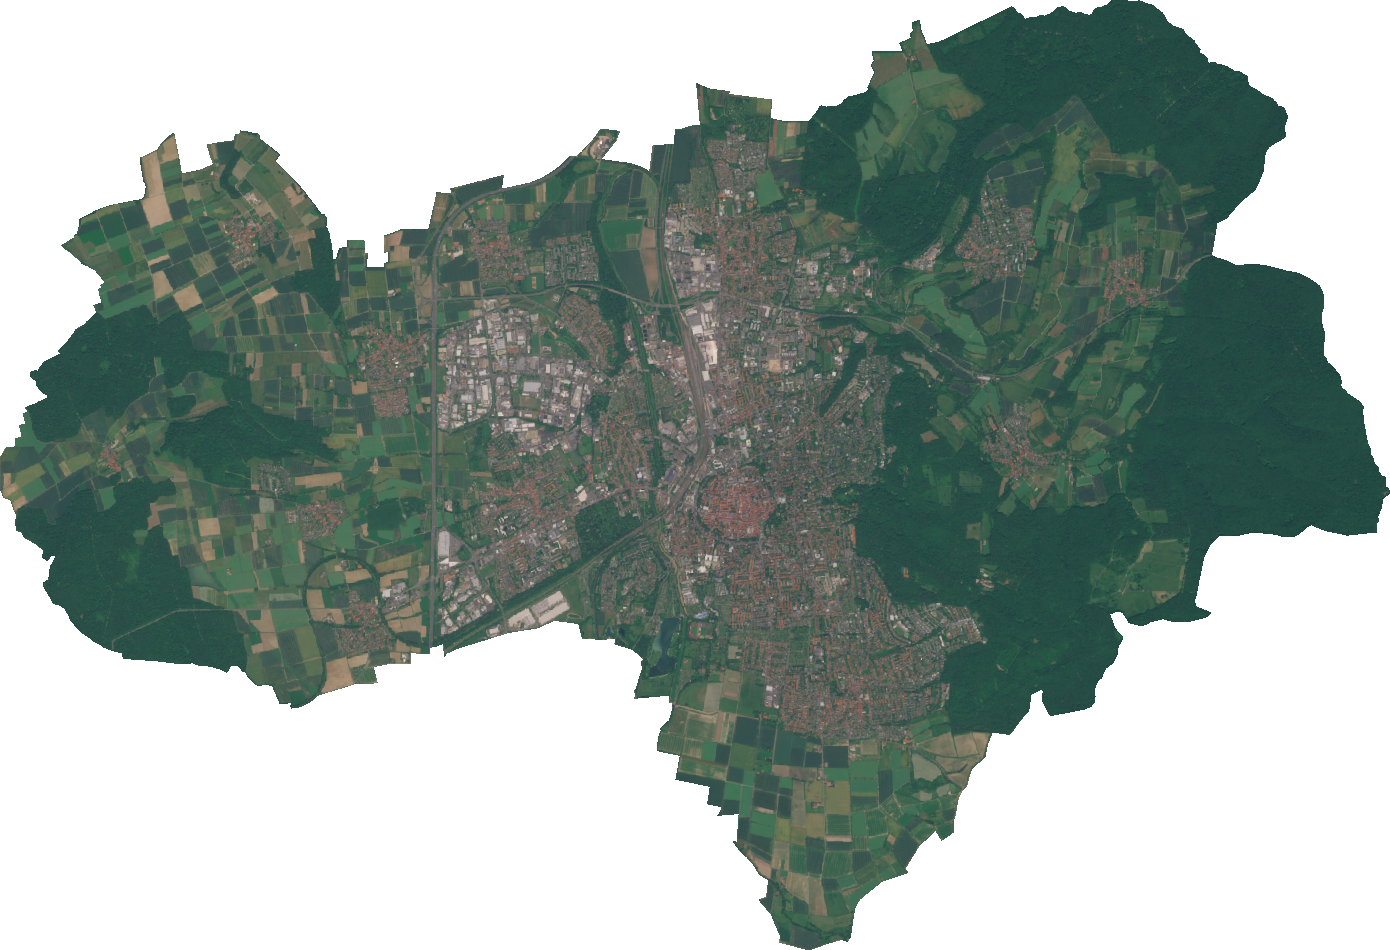

In [3]:
image_goettingen = Image.open(r"city_image_dataset/goettingen.png")
image_goettingen

As we can clearly see, Göttingen has a lot more greenery and less concentrated urban areas compared to Berlin.  
We would like to have a sensible scoring method that reflects this difference. Our first approach was to simply add up the RGB green values, normalize them by image size and compare the resulting scores. Here is the result:

In [4]:
def green_score_g_value(image):
    
    
    width, height = image.size
    
    # storing the only the green values for the "green-score"
    green_sum = 0
    
    # this will be important for normalizing the score based on image size
    non_empty_pixel_count = 0
    
    # iterate through the image and load all pixel color values
    for x in range(width):
        for y in range(height):
            
            r, g, b, alpha = image.getpixel((x, y))
            
            # count only pixels that actually contain content
            if(alpha != 0):
                
                # we need to keep track of the amount of pixels included in the sum
                non_empty_pixel_count += 1
            
                # count the pixel as green if the value is above a certain threshold
                green_sum += g
    
    # normalize the score by the size of the image
    # however, the direct size (height*width) is insufficient, ...
    # ... since the images might differ in their count of transparent/empty pixels
    green_score = green_sum/non_empty_pixel_count
    
    return green_score

In [5]:
green_score_berlin = green_score_g_value(image_berlin)
green_score_goettingen = green_score_g_value(image_goettingen)

print(f"Green-score for Berlin: {green_score_berlin}\nGreen-Score for Göttingen: {green_score_goettingen}")

Green-score for Berlin: 86.37389922149235
Green-Score for Göttingen: 93.51708940432462


The results are not too impressive. The values are remarkably similar, despite the high contrast in greenery. There are multiple possible explanations for this phenomenom:  
- the intensity of the sun makes the images incomparably bright
- other weather conditions
- time of day
- ...

Controlling for all of these values is not exactly possible, since even if you only set a fixed date, clouds will ruin the comparison between the images.  

We had a new idea: using a threshold of green values for each pixel to determine whether a pixel can be considered greenery at all. The intensity of the green value is ignored. This approach tries to account for variable lighting. Here is the approach:

In [6]:
def green_score_threshold(image, threshold):
    
    
    width, height = image.size
    
    # storing the only the green values for the "green-score"
    green_sum = 0
    
    # this will be important for normalizing the score based on image size
    non_empty_pixel_count = 0
    
    # iterate through the image and load all pixel color values
    for x in range(width):
        for y in range(height):
            
            r, g, b, alpha = image.getpixel((x, y))
            
            # count only pixels that actually contain content
            if(alpha != 0):
                
                # we need to keep track of the amount of pixels included in the sum
                non_empty_pixel_count += 1
            
                # count the pixel as green if the value is above a certain threshold
                if(g > threshold):
                    green_sum += 1
    
    # normalize the score by the size of the image
    # however, the direct size (height*width) is insufficient, ...
    # ... since the images might differ in their count of transparent/empty pixels
    green_score = green_sum/non_empty_pixel_count
    
    return green_score

In [7]:
for i in range (20):

    green_score_berlin = green_score_threshold(image_berlin, 5*i)
    green_score_goettingen = green_score_threshold(image_goettingen, 5*i)

    print(f"Threshold: {5*i}, Green-score for Berlin: {green_score_berlin}, Green-Score for Göttingen: {green_score_goettingen}")

Threshold: 0, Green-score for Berlin: 0.9999903664946684, Green-Score for Göttingen: 1.0
Threshold: 5, Green-score for Berlin: 0.9999855497420027, Green-Score for Göttingen: 1.0
Threshold: 10, Green-score for Berlin: 0.9999831413656698, Green-Score for Göttingen: 1.0
Threshold: 15, Green-score for Berlin: 0.9999795288011705, Green-Score for Göttingen: 1.0
Threshold: 20, Green-score for Berlin: 0.999967486919506, Green-Score for Göttingen: 1.0
Threshold: 25, Green-score for Berlin: 0.9999385864035114, Green-Score for Göttingen: 1.0
Threshold: 30, Green-score for Berlin: 0.9997374869797154, Green-Score for Göttingen: 1.0
Threshold: 35, Green-score for Berlin: 0.9959382733145882, Green-Score for Göttingen: 1.0
Threshold: 40, Green-score for Berlin: 0.9642392240211456, Green-Score for Göttingen: 1.0
Threshold: 45, Green-score for Berlin: 0.9537567660322602, Green-Score for Göttingen: 1.0
Threshold: 50, Green-score for Berlin: 0.9500418455387839, Green-Score for Göttingen: 1.0
Threshold: 55

This does not seem too convincing either. The most obvious problem is deciding on a threshold hyperparameter. The result fluctuates quite immensely based on that choice. Additionally, ignoring the greenery intensity of the spots has an obvious negative effect on the quality of the score.  

It became apparent that our current approach of using the base satellite images would not yield useful results. Luckily, Sentinel 3 provides a vegetation index called "NDVI". More specifically, we use the satellite "c_gls_NDVI300_202506210000_GLOBE_OLCI_V2.0.1_cog" to produce vegetation images of the cities. Here are both Berlin and Göttingen transformed based on the NDVI:

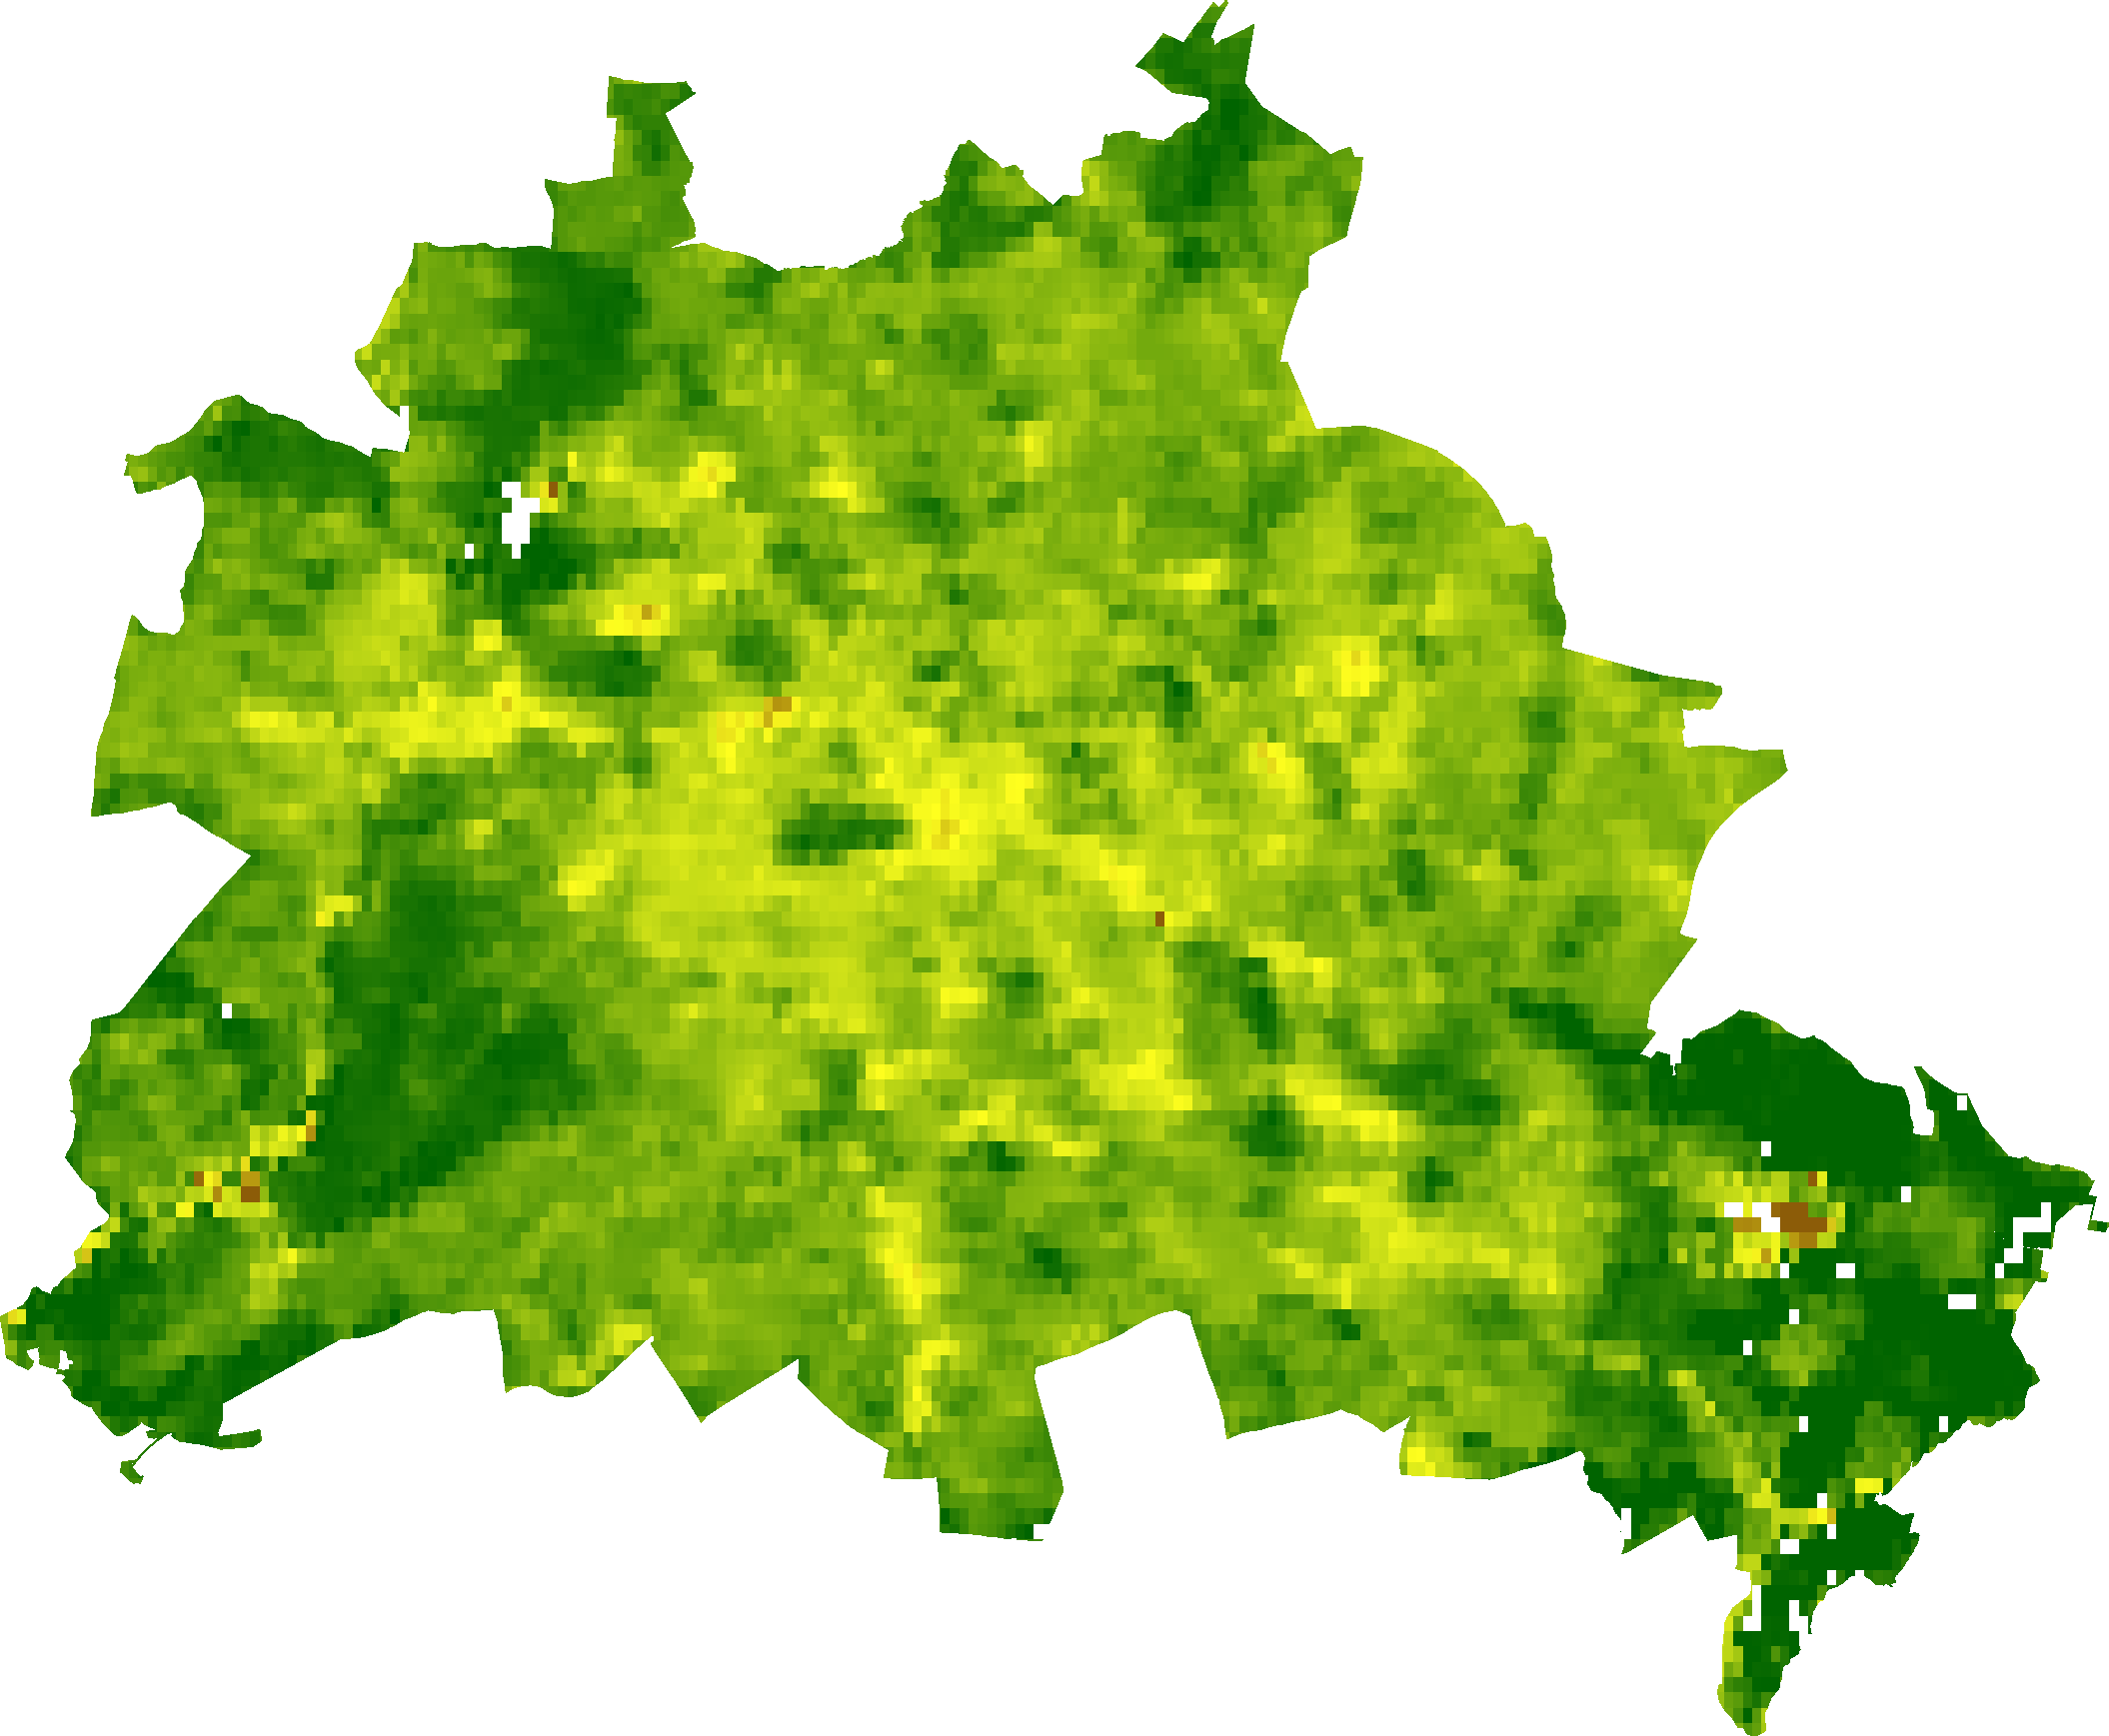

In [8]:
image_berlin_ndvi = Image.open(r"city_image_dataset/berlin_ndvi.png")
image_berlin_ndvi

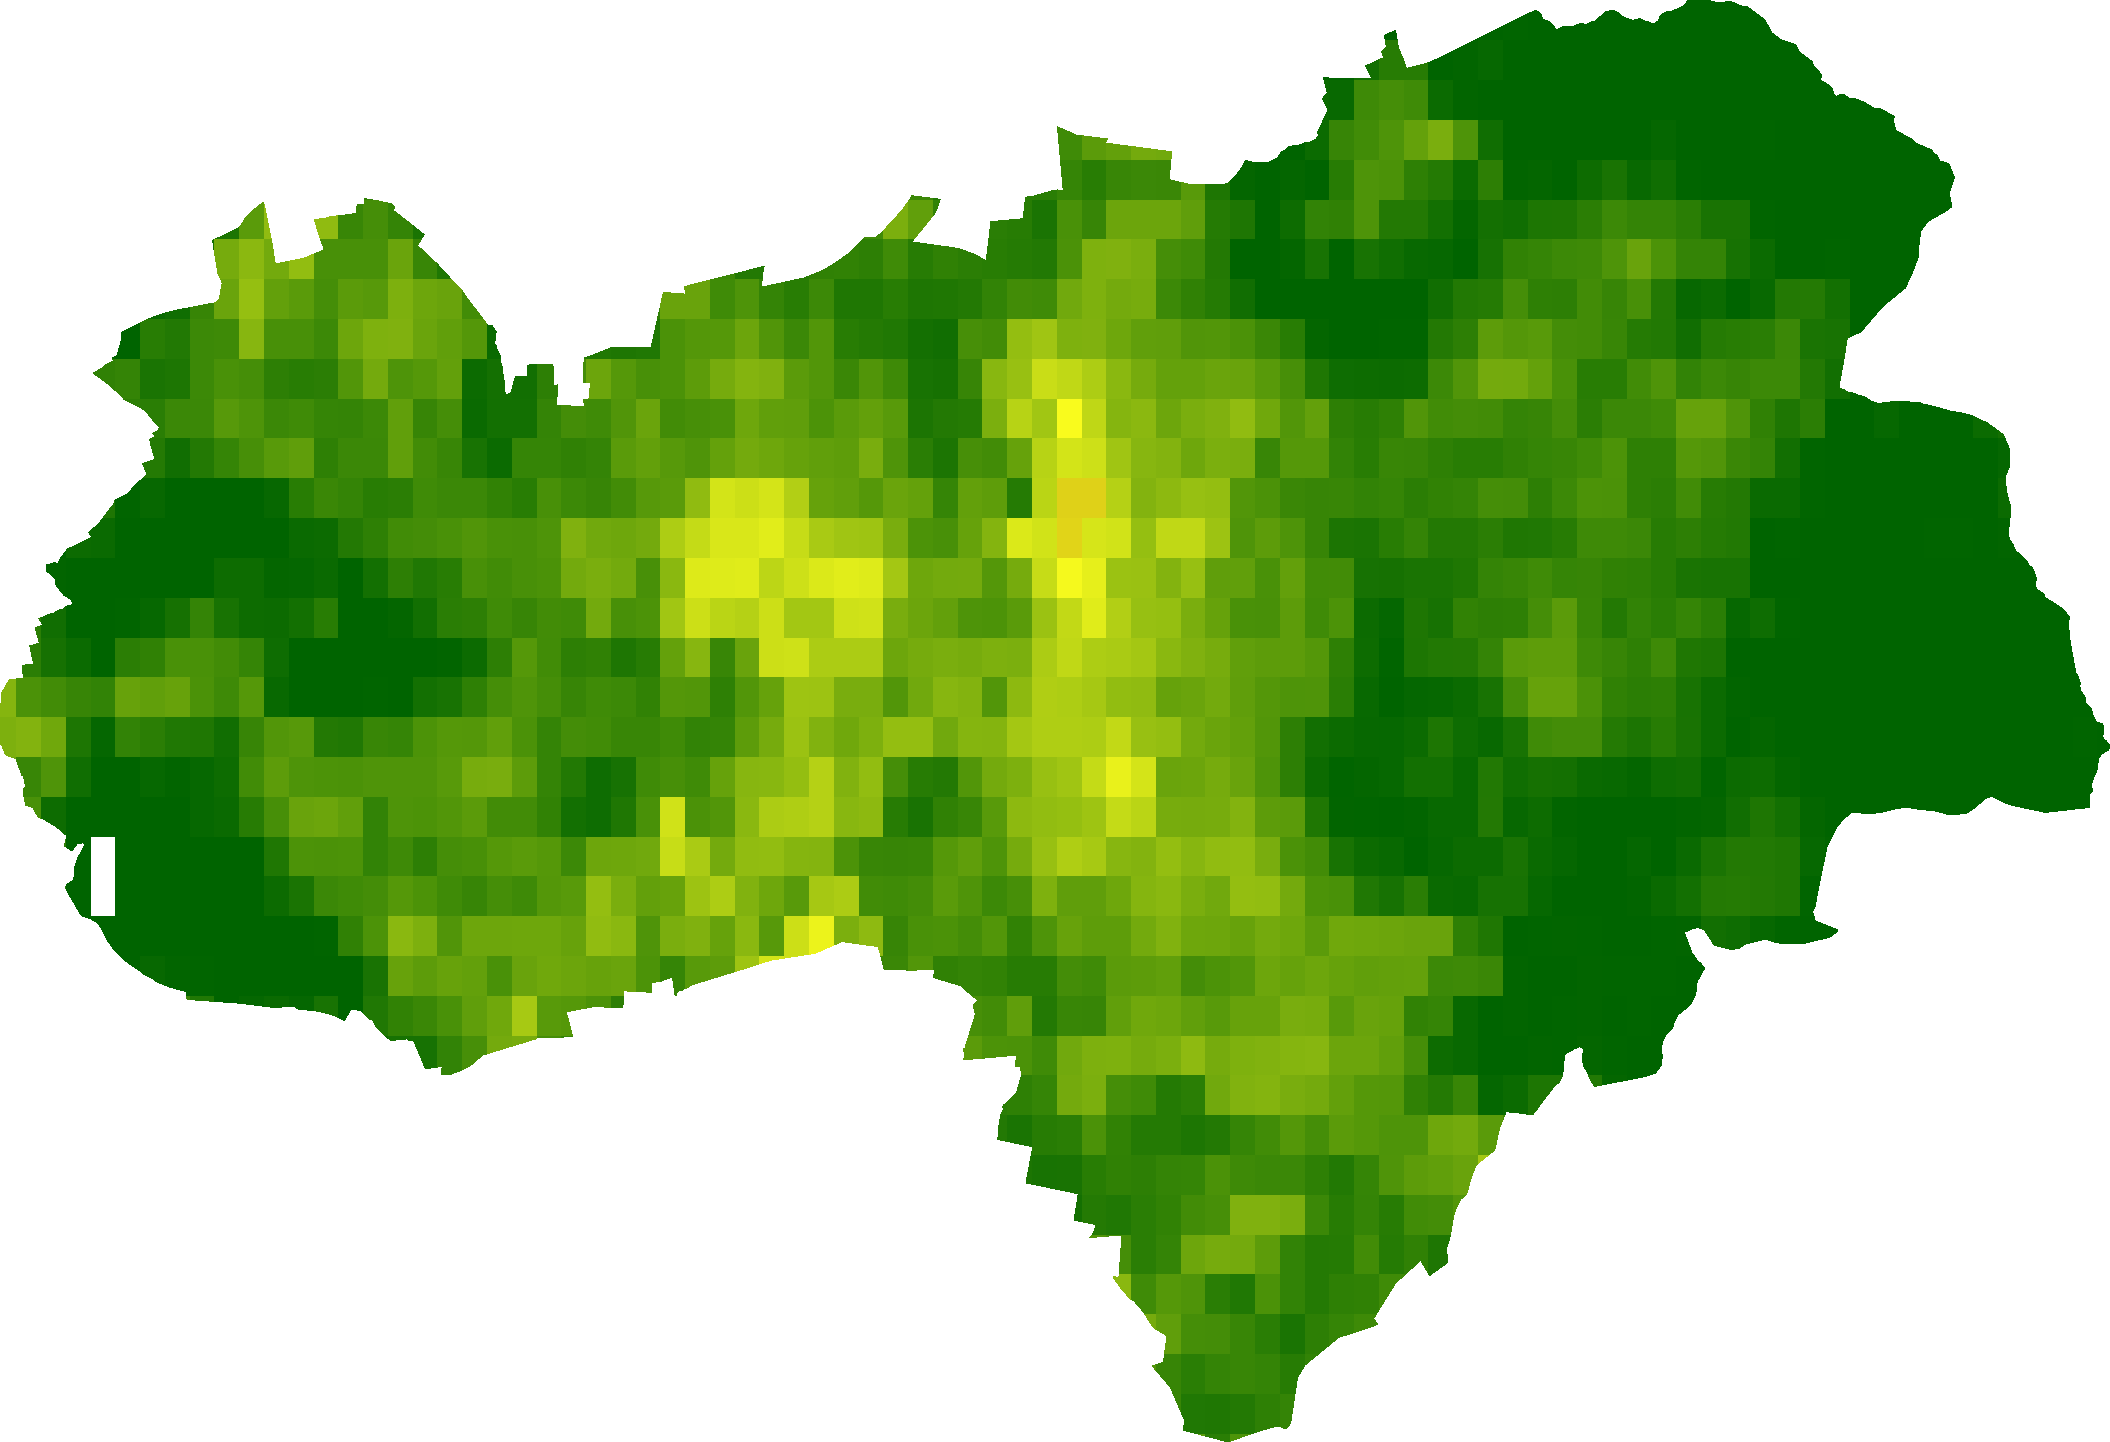

In [9]:
image_goettingen_ndvi = Image.open(r"city_image_dataset/goettingen_ndvi.png")
image_goettingen_ndvi

The visualization is not easy to interpret with the human eye. In short, the greener a pixel, the more vegetation and the healthier the vegetation. However, the more red a pixel, the bigger the factors decreasing the quality of the vegetation. One example of such a negative factor is a block of houses or streets. The yellow pixels in the images above are, therefore, areas where urban factors collide with the vegetation.

We use a standardized score for evaluating these NDVI images. It basically boils down to $(green-red)/(green+red)$. The higher the green values, the higher the score will be and the higher the red values, the lower the score will be. We were inspired by "https://www.techforwildlife.com/blog/2019/1/22/analysing-drone-and-satellite-imagery-using-vegetation-indices".

In [10]:
def green_score_ndvi(image):
    
    
    width, height = image.size   
    
    green_sum = 0
    red_sum = 0
    
    # this will be important for normalizing the score based on image size
    non_empty_pixel_count = 0
    
    # iterate through the image and load all pixel color values
    for x in range(width):
        for y in range(height):
            
            r, g, b, alpha = image.getpixel((x, y))
            
            # count only pixels that actually contain content
            if(alpha != 0):
                
                # we need to keep track of the amount of pixels included in the sum
                non_empty_pixel_count += 1
            
                # normalize to [0,1]
                green_sum += g/255
                red_sum += r/255
            
            # debugging 
            # print(f"r={r}, g={g}, b={b}, alpha={alpha}")
    
    # normalize the score by the size of the image
    # however, the direct size (height*width) is insufficient, ...
    # ... since the images might differ in their count of transparent/empty pixels 
    green_sum = green_sum/non_empty_pixel_count
    red_sum = red_sum/non_empty_pixel_count
    
    # debugging
    #print(f"g={green_sum}, r={red_sum}, g-r={green_sum-red_sum}")
    
    score = (green_sum - red_sum) / (green_sum + red_sum)
    return score

In [11]:
print(green_score_ndvi(image_berlin_ndvi))
print(green_score_ndvi(image_goettingen_ndvi))

0.1997623930843307
0.3808291395639449


This score appears to be a lot more reasonable compared to the previous approaches and it also makes sense conceptually. However, the score seems a bit pessimistic and not as sensitive to the urban greenery differences as we would like it to be.

In [12]:
from os import listdir

# store results
city_score_map = {}

# used later
score_sum = 0

# iterate through all images and calculate the respective green-score
for filename in listdir("city_image_dataset"):
    # we use the "Normalized Difference Vegetation Index" as a basis for vegetation comparison
    if("ndvi" in filename):
        city_image = Image.open(f"city_image_dataset/{filename}")
        score = green_score_ndvi(city_image)
        
        names_split = filename.split('_')
        full_name = ""
        
        # len()-1 to ignore last "ndvi.png" part of the file name
        for i in range(len(names_split)-1):
            full_name += names_split[i].capitalize() + " "
            
        # remove last emtpy space
        full_name = full_name[:-1]
        
        # store results
        city_score_map[full_name] = score
        
        score_sum += score
        
        
def print_dict(score_dict):
    for full_name in score_dict.keys():
        print(f"{full_name}: {score_dict[full_name]}")

In [13]:
print_dict(city_score_map)

Aachen: 0.32552569452906455
Augsburg: 0.24317208547699942
Bergisch Gladbach: 0.41471234811668795
Berlin: 0.1997623930843307
Bielefeld: 0.32243731896763467
Bochum: 0.2593242372763487
Bonn: 0.3179330075067507
Bottrop: 0.30822892224652676
Braunschweig: 0.27285734409615736
Bremen: 0.2491925939678651
Bremerhaven: 0.19574869298098774
Chemnitz: 0.34487038849334084
Darmstadt: 0.3370180011670043
Dessau-roßlau: 0.28552260009839725
Dortmund: 0.2758278125839647
Dresden: 0.25701766635814965
Duesseldorf: 0.20130734859885283
Duisburg: 0.20674480113602323
Erfurt: 0.3007396896558234
Erlangen: 0.1880161346328393
Essen: 0.26258362425381393
Frankfurt Am Main: 0.20608419802308955
Freiburg Im Breisgau: 0.3613709658207897
Gelsenkirchen: 0.2379251734154528
Goettingen: 0.3808291395639449
Guetersloh: 0.2851211031389264
Hagen: 0.3987693537068704
Halle: 0.4671857279495074
Hamburg: 0.25481793336761566
Hamm: 0.2804566887994341
Hannover: 0.20905876592354972
Heidelberg: 0.3038224332300856
Heilbronn: 0.233575065868904

Now, we would like to normalize these values to make them more expressive. To this end, we substract the mean and divide by the standard deviation.

In [14]:
# calculate mean and std. deviation
score_mean = score_sum/len(city_score_map.keys())

deviation_sum = 0

for score in city_score_map.values():
    deviation_sum += (score-score_mean)**2
        
score_std_dev = (deviation_sum/len(city_score_map.keys()))**(1/2)

# normalize scores
normalized_city_score_map = {}

for full_name in city_score_map.keys():
    normalized_city_score_map[full_name] = (city_score_map[full_name]-score_mean)/score_std_dev

The score values are now normalized scores with higher values indicating a greener city and a value close to 0 indicating average city greenery.

In [15]:
print_dict(normalized_city_score_map)

Aachen: 0.5947090960601052
Augsburg: -0.5296619608146883
Bergisch Gladbach: 1.8123714803527533
Berlin: -1.1223330322585292
Bielefeld: 0.5525436083055146
Bochum: -0.30913717509516053
Bonn: 0.4910463952985472
Bottrop: 0.35855684534885407
Braunschweig: -0.12437012246765707
Bremen: -0.4474641607095504
Bremerhaven: -1.1771319448881028
Chemnitz: 0.8588215526712263
Darmstadt: 0.7516131723861387
Dessau-roßlau: 0.048548192111917375
Dortmund: -0.08381441602693888
Dresden: -0.34062871032845543
Duesseldorf: -1.101239806537364
Duisburg: -1.027002449774291
Erfurt: 0.2563066044654625
Erlangen: -1.2827043041608703
Essen: -0.2646368742243192
Frankfurt Am Main: -1.0360216418754462
Freiburg Im Breisgau: 1.0841033804169735
Gelsenkirchen: -0.6012978748672291
Goettingen: 1.3497651726356124
Guetersloh: 0.043066567616664955
Hagen: 1.5947023134437168
Halle: 2.5287887718295523
Hamburg: -0.3706615909256542
Hamm: -0.020616524611646054
Hannover: -0.9954099662915409
Heidelberg: 0.2983951988885178
Heilbronn: -0.6606